## Setup

In [1]:
from pathlib import Path
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import ast
import numpy as np
from numpy.random import default_rng
from typing import Tuple, Optional, Dict, Any

from src.utils import grid_search_dict

from fct import run_exp, pmmr_exp, kpv_exp, NMMR_exp, calc_haw, gen_haw, ha_effect, save_data

C:\Users\Benedikt\anaconda3new\envs\kompa\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config

In [2]:
experiment_name = "cosine"
n_sample = 1000
beta_0 = 1
beta_a = 2
delta = 1.5
gamma = 0.5
lam_z = 3
lam_u = 2
U_noise = np.sqrt(0.1)
A_noise = np.sqrt(0.1)
W_noise = np.sqrt(0.1)
Z_noise = np.sqrt(0.1)
a_start = -5
a_end = 5

data_dic = {
      "name" : experiment_name,
      "n_sample" : n_sample,
      "beta_0": beta_0,
      "beta_a": beta_a,
      "delta": delta,
      "gamma": gamma,
      "lam_z": lam_z, 
      "lam_u": lam_u, 
      "U_noise": U_noise,
      "A_noise": A_noise,
      "Z_noise": Z_noise,
      "W_noise": W_noise,
      "a_start": a_start,
      "a_end": a_end,
}

pmmr_configs = {
        "name": "pmmr",
        "lam1": np.logspace(np.log10(1/(450)**2), np.log10(0.25), 50),
        "lam2": 0.01,
        "scale": 0.5,
        "data_scaling": True
}

kpv_configs = {
        "name": "kpv",
        "lam1_max": 0.01,
        "lam1_min":  0.0001,
        "n_lam1_search": 25,
        "lam2_max": 0.01,
        "lam2_min": 0.0001,
        "n_lam2_search": 25,
        "split_ratio": 0.5,
        "scale": 0.5,
        "data_scaling": True,
}

nmmr_u_configs = {
    "name": "nmmr",
    "n_epochs": [2000],
    "batch_size": 100,
    "log_metrics": "True",
    "learning_rate": [0.003],
    "l2_penalty": [3e-06],
    "loss_name": "U_statistic",
    "network_depth": [4],
    "network_width": [80]
}

nmmr_v_configs = {
    "name": "nmmr",
    "n_epochs": [2000],
    "batch_size": 100,
    "log_metrics": "True",
    "learning_rate": [0.003],
    "l2_penalty": [3e-06],
    "loss_name": "V_statistic",
    "network_depth": [3],
    "network_width": [80]
}

## Evaluations

#### Grid search is unfair for KPV!

In [3]:
%%time
sd_list = [5949, 7422, 4388, 2807, 5654, 5518, 1816, 1102, 9886, 1656, 
           4379, 2029, 8455, 4987, 4259, 2533, 9783, 7987, 1009, 2297]

sd_list = [5949, 7422, 4388, 2807, 5654, 5518, 1816, 1102, 9886, 1656]

# save results
results_pmmr = run_exp(model_config = pmmr_configs, data_config=data_dic, sd_list=sd_list)
print("PMMR finished")

PMMR finished
CPU times: total: 48min 9s
Wall time: 11min 42s


In [4]:
%%time
results_kpv = run_exp(model_config = kpv_configs, data_config=data_dic, sd_list=sd_list)
print("KPV finished")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


KPV finished


In [5]:
%%time
results_nmmr_u = run_exp(model_config = nmmr_u_configs, data_config=data_dic, sd_list=sd_list)
print("NMMR-U finished")

100%|██████████| 2000/2000 [04:04<00:00,  8.18it/s]


NMMR-U finished


In [6]:
%%time
results_nmmr_v = run_exp(model_config = nmmr_v_configs, data_config=data_dic, sd_list=sd_list)
print("NMMR-V finished")
df_save = pd.DataFrame(columns=['model', 'pred_avg', 'train_data', 'test_data', 'pred_all', 
                                'mse_avg', 'mae_avg', 'mse_all', 'mae_all', 'param_opt', 'error', 
                                'std', 'error_abs', 'std_abs', 'model_config', 'data_config'])
df_save = df_save.append([results_pmmr, results_kpv, results_nmmr_u, results_nmmr_v])
save_data(df_save, data_dic)

100%|██████████| 2000/2000 [04:00<00:00,  8.31it/s]


NMMR-V finished


In [7]:
df_save

,model,pred_avg,train_data,test_data,pred_all,mse_avg,mae_avg,mse_all,mae_all,param_opt,error,std,error_abs,std_abs,model_config,data_config,sd_list
0,pmmr,"[0.24445945447376433, 0.2903118742483889, 0.34...","([[-1.1342450224565417], [-0.07759495951465596...","([[-5.0], [-4.898989898989899], [-4.7979797979...","[[0.18444292108495758, 0.2660794784092065, 0.2...",0.163841,0.275854,"[0.1583929552684538, 0.14719257198383953, 0.17...","[0.26509895070915257, 0.247842826314702, 0.278...","[0.0058319442463094055, 4.938271604938276e-06,...","[[-0.05186864137858094, -0.13350519870282984, ...","[[0.05944650000861352], [0.06373184125915365],...","[[0.05186864137858094, 0.13350519870282984, 0....","[[0.05944650000861352], [0.0551984055359559], ...","{'name': 'pmmr', 'lam1': [4.938271604938276e-0...","{'name': 'cosine', 'n_sample': 1000, 'beta_0':...","[5949, 7422, 4388, 2807, 5654, 5518, 1816, 110..."
1,kpv,"[0.14514269, 0.2011298, 0.26600868, 0.33927745...","([[-1.1342450224565417], [-0.07759495951465596...","([[-5.0], [-4.898989898989899], [-4.7979797979...","[[0.13856567, 0.2589197, 0.39595595, -0.080924...",0.146837,0.247923,"[0.1243478, 0.11953584, 0.13037342, 0.23572917...","[0.20928995, 0.24414329, 0.2458219, 0.32744423...","[[0.002154434690031882, 0.0001], [0.0031622776...","[[-0.005991394717794807, -0.12634540637264863,...","[[0.16188750399675625], [0.18353398777386362],...","[[0.005991394717794807, 0.12634540637264863, 0...","[[0.09331963087147353], [0.10371670801444989],...","{'name': 'kpv', 'lam1_max': 0.01, 'lam1_min': ...","{'name': 'cosine', 'n_sample': 1000, 'beta_0':...","[5949, 7422, 4388, 2807, 5654, 5518, 1816, 110..."
2,nmmr_U_statistic,"[1.8671968, 1.8255165, 1.7855107, 1.7458658, 1...","([[-1.1342450224565417], [-0.07759495951465596...","([[-5.0], [-4.898989898989899], [-4.7979797979...","[[2.4412446, 1.0610673, 2.4757357, 1.7834976, ...",0.505721,0.494705,"[0.4967897503773818, 1.4685121508698524, 0.362...","[0.519289542537335, 0.8341363496352077, 0.4210...","[{'name': 'nmmr', 'batch_size': 100, 'log_metr...","[[-2.3086703224969924, -0.928493063051802, -2....","[[0.7968421714615246], [0.7580382029994356], [...","[[2.3086703224969924, 0.928493063051802, 2.343...","[[0.7645396516267713], [0.7155098508459442], [...","{'name': 'nmmr', 'n_epochs': [2000], 'batch_si...","{'name': 'cosine', 'n_sample': 1000, 'beta_0':...","[5949, 7422, 4388, 2807, 5654, 5518, 1816, 110..."
3,nmmr_V_statistic,"[0.5077857, 0.5542694, 0.6251812, 0.70880735, ...","([[-1.1342450224565417], [-0.07759495951465596...","([[-5.0], [-4.898989898989899], [-4.7979797979...","[[0.005025285, 2.4444933, 0.8829631, 0.1465259...",0.076656,0.160787,"[0.051842734308651106, 0.26470060094132997, 0....","[0.15018754416688035, 0.22631426874689706, 0.2...","[{'name': 'nmmr', 'batch_size': 100, 'log_metr...","[[0.12754899487589583, -2.3119190140558303, -0...","[[0.7244989686807698], [0.6910831870774595], [...","[[0.12754899487589583, 2.3119190140558303, 0.7...","[[0.6786095010604543], [0.6239708004338993], [...","{'name': 'nmmr', 'n_epochs': [2000], 'batch_si...","{'name': 'cosine', 'n_sample': 1000, 'beta_0':...","[5949, 7422, 4388, 2807, 5654, 5518, 1816, 110..."


### Plot

#### Get Data

In [8]:
# results_pmmr = df_save[df_save["model"] == "pmmr"].to_dict(orient='records')[0]
# results_kpv = df_save[df_save["model"] == "kpv"].to_dict(orient='records')[0]
# results_nmmr_u = df_save[df_save["model"] == "nmmr_U_statistic"].to_dict(orient='records')[0]
# results_nmmr_v = df_save[df_save["model"] == "nmmr_V_statistic"].to_dict(orient='records')[0]

A_train = np.squeeze(results_pmmr["train_data"].treatment)
Y_train = np.squeeze(results_pmmr["train_data"].outcome)
A_test = np.squeeze(results_pmmr["test_data"].treatment)
Y_test = np.squeeze(results_pmmr["test_data"].structural)

Y_pred_pmmr = results_pmmr["pred_avg"]
Y_pred_kpv = results_kpv["pred_avg"]
Y_pred_nmmr_u = results_nmmr_u["pred_avg"]
Y_pred_nmmr_v = results_nmmr_v["pred_avg"]

std_pmmr = np.squeeze(results_pmmr["std"])
std_kpv = np.squeeze(results_kpv["std"])
std_nmmr_u = np.squeeze(results_nmmr_u["std"])
std_nmmr_v = np.squeeze(results_nmmr_v["std"])

std_pmmr_abs = np.squeeze(results_pmmr["std_abs"])
std_kpv_abs = np.squeeze(results_kpv["std_abs"])
std_nmmr_u_abs = np.squeeze(results_nmmr_u["std_abs"])
std_nmmr_v_abs = np.squeeze(results_nmmr_v["std_abs"])

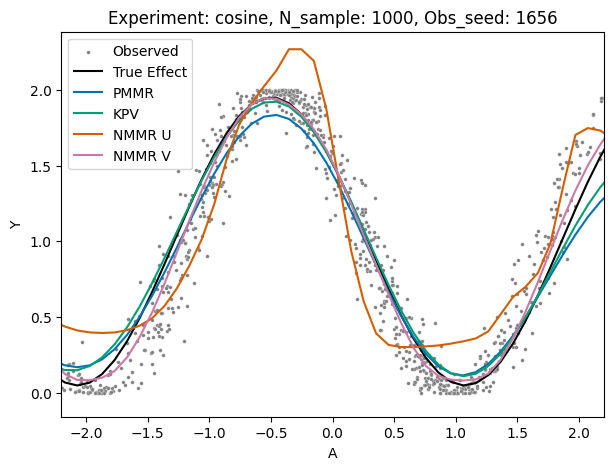

In [9]:
import importlib
importlib.reload(plt)


plt.style.use('seaborn-colorblind')
plt.figure(figsize=(7, 5))
# Obs & True values
sns.scatterplot(x=A_train, y=Y_train, color='gray', label='Observed', s=7)
plt.plot(A_test, Y_test, color='black', label="True Effect", linestyle="solid")

# Predictions
plt.plot(A_test, Y_pred_pmmr,  label="PMMR", linestyle="solid")
plt.plot(A_test, Y_pred_kpv,  label="KPV", linestyle="solid")
plt.plot(A_test, Y_pred_nmmr_u, label="NMMR U", linestyle="solid")
plt.plot(A_test, Y_pred_nmmr_v, label="NMMR V", linestyle="solid")

plt.title(f'Experiment: {experiment_name}, N_sample: {n_sample}, Obs_seed: {sd_list[-1]}')
plt.xlabel('A')
plt.xlim([-2.2, 2.2])
plt.ylabel('Y')
# plt.ylim([0, 50])
plt.legend()
plt.savefig(f"plots/plot_experiment_{experiment_name}_n_sample_{n_sample}_obs_seed_{sd_list[-1]}", dpi = 300, format="pdf")
plt.show()

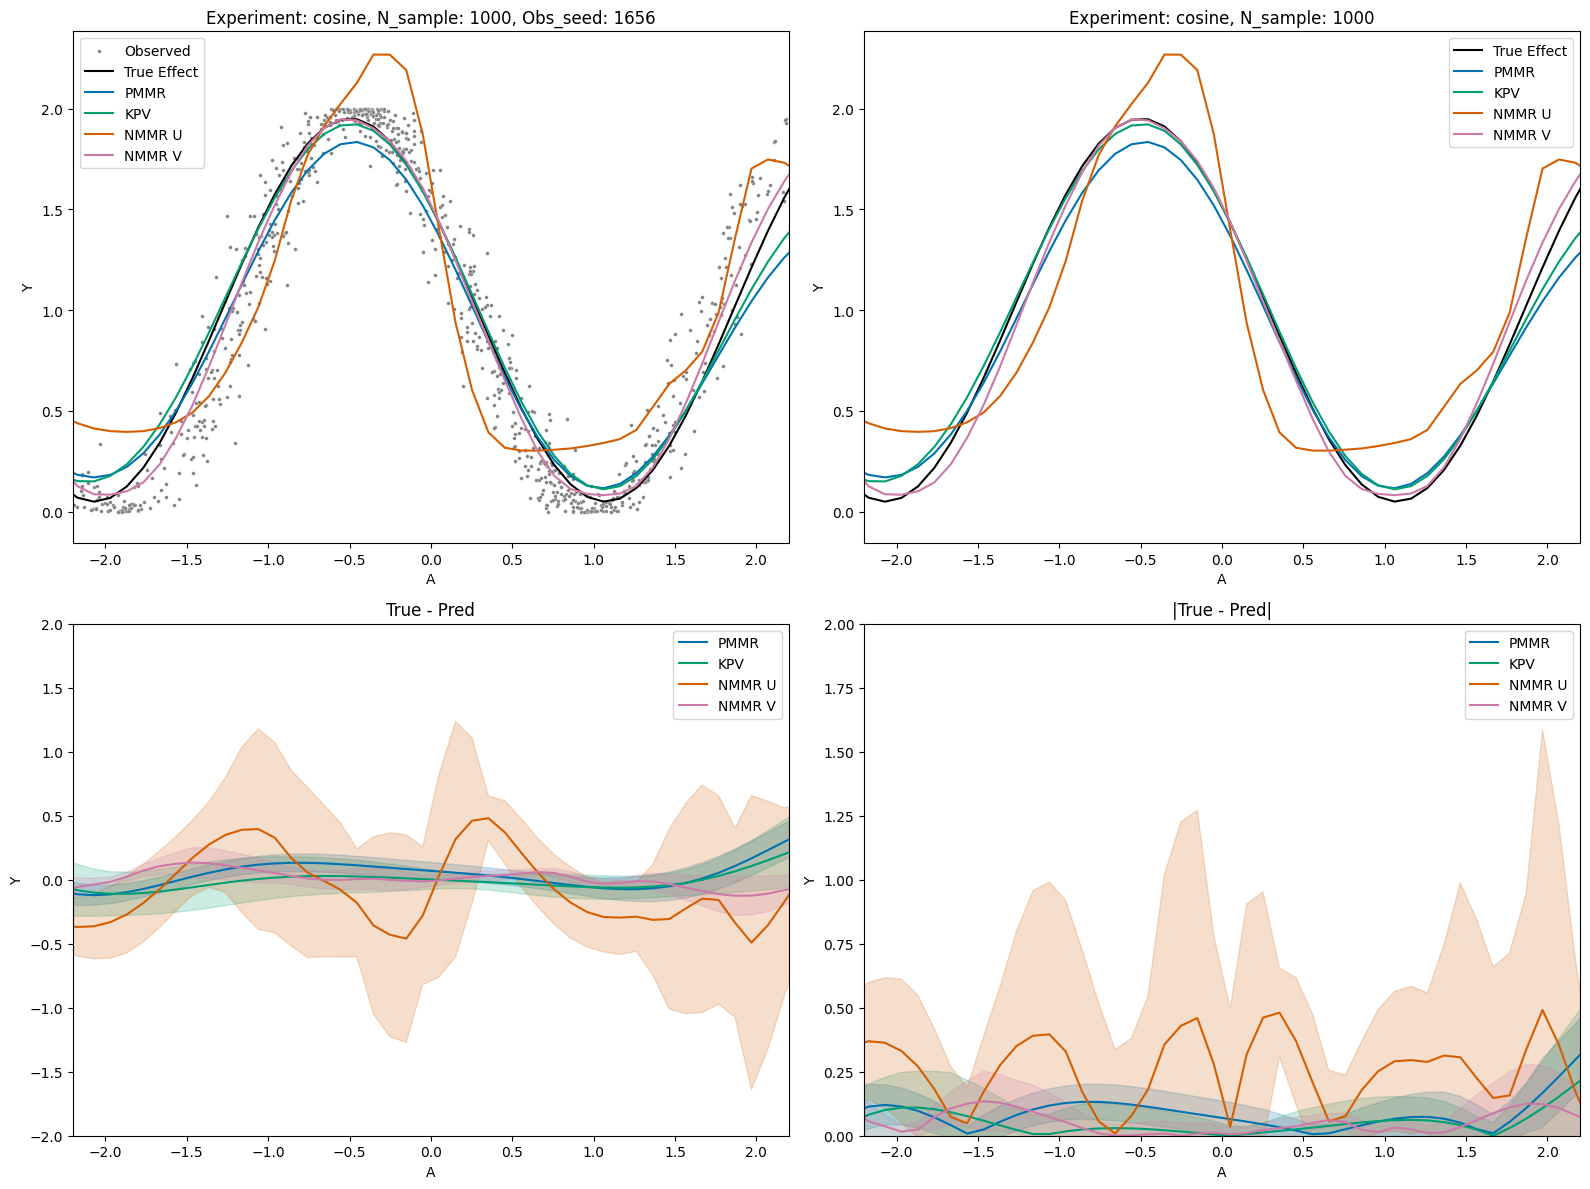

In [12]:
import importlib
importlib.reload(plt)

plt.style.use('seaborn-colorblind')
fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(2, 2, 1)
sns.scatterplot(x=A_train, y=Y_train, color='gray', label='Observed', s=7, ax=ax1)
ax1.plot(A_test, Y_test, color='black', label="True Effect", linestyle="solid")
ax1.plot(A_test, Y_pred_pmmr,  label="PMMR", linestyle="solid")
ax1.plot(A_test, Y_pred_kpv,  label="KPV", linestyle="solid")
ax1.plot(A_test, Y_pred_nmmr_u, label="NMMR U", linestyle="solid")
ax1.plot(A_test, Y_pred_nmmr_v, label="NMMR V", linestyle="solid")

ax1.set_title(f'Experiment: {experiment_name}, N_sample: {n_sample}, Obs_seed: {sd_list[-1]}')
ax1.set_xlabel('A')
ax1.set_xlim([-2.2, 2.2])
ax1.set_ylabel('Y')
# ax1.set_ylim([0, 50])
ax1.legend()

####

ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(A_test, Y_test, color='black', label="True Effect", linestyle="solid")
ax2.plot(A_test, Y_pred_pmmr,  label="PMMR", linestyle="solid")
ax2.plot(A_test, Y_pred_kpv,  label="KPV", linestyle="solid")
ax2.plot(A_test, Y_pred_nmmr_u, label="NMMR U", linestyle="solid")
ax2.plot(A_test, Y_pred_nmmr_v, label="NMMR V", linestyle="solid")

ax2.set_title(f'Experiment: {experiment_name}, N_sample: {n_sample}')
ax2.set_xlabel('A')
ax2.set_xlim([-2.2, 2.2])
ax2.set_ylabel('Y')
# ax2.set_ylim([0, 50])
ax2.legend()

### True vs Pred
alpha = 0.2
ax3 = fig.add_subplot(2, 2, 3)
line, = ax3.plot(A_test, Y_test - Y_pred_pmmr,  label="PMMR", linestyle="solid")
color = line.get_color()
ax3.fill_between(A_test, Y_test - Y_pred_pmmr - 2*std_pmmr, Y_test - Y_pred_pmmr + 2*std_pmmr, alpha=alpha, color=color)

line, = ax3.plot(A_test, Y_test - Y_pred_kpv,  label="KPV", linestyle="solid")
color = line.get_color()
ax3.fill_between(A_test, Y_test - Y_pred_kpv - 2*std_kpv, Y_test - Y_pred_kpv + 2*std_kpv, alpha=alpha, color=color)

line, = ax3.plot(A_test, Y_test - Y_pred_nmmr_u, label="NMMR U", linestyle="solid")
color = line.get_color()
ax3.fill_between(A_test, Y_test - Y_pred_nmmr_u - 2*std_nmmr_u, Y_test - Y_pred_nmmr_u + 2*std_nmmr_u, alpha=alpha, color=color)

line, = ax3.plot(A_test, Y_test - Y_pred_nmmr_v, label="NMMR V", linestyle="solid")
color = line.get_color()
ax3.fill_between(A_test, Y_test - Y_pred_nmmr_v - 2*std_nmmr_v, Y_test - Y_pred_nmmr_v + 2*std_nmmr_v, alpha=alpha, color=color)

ax3.set_title('True - Pred')
ax3.set_xlabel('A')
ax3.set_xlim([-2.2, 2.2])
ax3.set_ylabel('Y')
ax3.set_ylim([-2, 2])
ax3.legend()

#### | True - Pred|
alpha = 0.2
ax4 = fig.add_subplot(2, 2, 4)

line, = ax4.plot(A_test, np.abs(Y_test - Y_pred_pmmr),  label="PMMR", linestyle="solid")
color = line.get_color()
ax4.fill_between(A_test, np.abs(Y_test - Y_pred_pmmr) - 2*std_pmmr_abs, np.abs(Y_test - Y_pred_pmmr) + 2*std_pmmr_abs, alpha=alpha, color=color)

line, = ax4.plot(A_test, np.abs(Y_test - Y_pred_kpv),  label="KPV", linestyle="solid")
color = line.get_color()
ax4.fill_between(A_test, np.abs(Y_test - Y_pred_kpv) - 2*std_kpv_abs, np.abs(Y_test - Y_pred_kpv) + 2*std_kpv_abs, alpha=alpha, color=color)

line, = ax4.plot(A_test, np.abs(Y_test - Y_pred_nmmr_u), label="NMMR U", linestyle="solid")
color = line.get_color()
ax4.fill_between(A_test, np.abs(Y_test - Y_pred_nmmr_u) - 2*std_nmmr_u_abs, np.abs(Y_test - Y_pred_nmmr_u) + 2*std_nmmr_u_abs, alpha=alpha, color=color)

line, = ax4.plot(A_test, np.abs(Y_test - Y_pred_nmmr_v), label="NMMR V", linestyle="solid")
color = line.get_color()
ax4.fill_between(A_test, np.abs(Y_test - Y_pred_nmmr_v) - 2*std_nmmr_v_abs, np.abs(Y_test - Y_pred_nmmr_v) + 2*std_nmmr_v_abs, alpha=alpha, color=color)

ax4.set_title('|True - Pred|')
ax4.set_xlabel('A')
ax4.set_xlim([-2.2, 2.2])
ax4.set_ylabel('Y')
ax4.set_ylim([0, 2])
ax4.legend()


###########
plt.tight_layout()
time_stamp = datetime.datetime.now()
time_string = time_stamp.strftime("%Y_%m_%d_%H_%M_%S")
plt.savefig(f"plots/all_plot_experiment_{experiment_name}_n_sample_{n_sample}_obs_seed_{sd_list[-1]}_n_seed_{len(sd_list)}_time_{time_string}", dpi = 300, format="pdf")
plt.show()
